In [2]:
%cd /content/drive/MyDrive/pophealth

/content/drive/MyDrive/pophealth


# Importing Necessary Python Libraries


In [3]:
!pip install --quiet python-Levenshtein==0.12.0



     |████████████████████████████████| 48 kB 5.5 MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1


In [4]:
# Dataframe building and Analysis library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import random

# Word Stemming Library to make root words in a String
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Words to Vectors Library
from sklearn.feature_extraction.text import CountVectorizer

# Similarity and Distance Metrics Library
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial import distance
from Levenshtein import distance as levenshtein_distance

# Data Extraction and Exploratory Analysis
 

In [6]:
# Dataset in two files (test and train) directly downloaded from Blob Storage in Azure Cloud
test = pd.read_csv(r'https://researchproject.blob.core.windows.net/project/drugsComTest_raw.csv', na_values=['(NA)']).fillna(0)

train = pd.read_csv(r'https://researchproject.blob.core.windows.net/project/drugsComTrain_raw.csv', na_values=['(NA)']).fillna(0)
df = pd.concat([test, train], ignore_index=True, sort=False)
#Dropping Unneccesary Columns
df = df.drop(columns=['date','Unnamed: 7', 'Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'])

# Converting 'Rating' and 'UsefulCount' into float type for generating new column of 'most_reviewed' drugs
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['usefulCount'] = pd.to_numeric(df['usefulCount'], errors='coerce')
df['most_reviewed'] = df['rating'] * df['usefulCount']
df = df[['uniqueID','drugName','condition','review','most_reviewed']]
df.head()

,uniqueID,drugName,condition,review,most_reviewed
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",220.0
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",136.0
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",27.0
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",315.0
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",36.0


**Plotting the graph for Top 10 Most Reviewed Drugs**

In [7]:
#Sorting Top 10 Drugs in Dataset
df = df.sort_values(by='most_reviewed', ascending=False, ignore_index=True)
df = df.drop_duplicates(subset = ['condition'], ignore_index=True)
df = df.drop_duplicates(subset = ['drugName'], ignore_index=True)
df_graph = df[['drugName','most_reviewed']]
df_graph = df_graph.head(10)
df_graph

,drugName,most_reviewed
0,Sertraline,12910.0
1,Mirena,12470.0
2,Adipex-P,7960.0
3,Oxycodone,6255.0
4,Celexa,5544.0
5,BuSpar,5265.0
6,Clomid,4860.0
7,Topiramate,4670.0
8,Denosumab,4480.0
9,Amoxicillin,4080.0


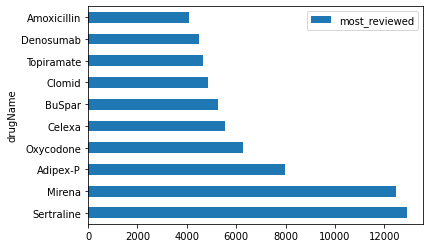

In [8]:
#MatplotLb Barh graph
df_graph.plot(kind='barh', x='drugName', y='most_reviewed')
plt.show()

In [9]:
#Removing unwanted characters and splitting in words the string value of 'Review' column
df['review'] = df['review'].map(lambda x: re.sub(r'["&#039;"]','', x))
df['review'] = df['review'].apply(lambda x: x.split())
#Now Concatnating Drugs and Condition values with Reviews to build metadata of drugs
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['condition_list'] = df['condition'].apply(lambda x: "".join(x))
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: "".join(x))
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())
df['tags'] = df['drugName_list'] + df['condition_list'] + df['review']
df.head()

,uniqueID,drugName,condition,review,most_reviewed,condition_list,drugName_list,tags
0,96616,Sertraline,Depression,"[I, remember, reading, peoples, opinions,, onl...",12910.0,[Depression],[Sertraline],"[Sertraline, Depression, I, remember, reading,..."
1,182560,Mirena,Birth Control,"[I, have, had, my, IUD, for, over, a, year, no...",12470.0,"[Birth, Control]",[Mirena],"[Mirena, Birth, Control, I, have, had, my, IUD..."
2,52305,Adipex-P,Weight Loss,"[I, have, used, this, pill, off, and, on, for,...",7960.0,"[Weight, Loss]",[Adipex-P],"[Adipex-P, Weight, Loss, I, have, used, this, ..."
3,189774,Oxycodone,Pain,"[Ahhhh,, the, dreaded, drug...no, matter, what...",6255.0,[Pain],[Oxycodone],"[Oxycodone, Pain, Ahhhh,, the, dreaded, drug....."
4,89748,Celexa,Anxiety and Stress,"[I, work, for, a, large, Fire, Department., I,...",5544.0,"[Anxiety, and, Stress]",[Celexa],"[Celexa, Anxiety, and, Stress, I, work, for, a..."


In [ ]:
#Creating New Dataframe with relevant columns for further analysis
new_df = df[['uniqueID','drugName','condition','tags']]
new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())

**Stemming**

In [11]:
import nltk
nltk.download('wordnet')
# PorterStemmer is applied to check root words
ps = PorterStemmer()
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)
new_df_ps = new_df[['uniqueID','drugName','condition','tags']]
new_df_ps['tags'] = new_df_ps['tags'].apply(stem)
new_df_ps['tags'][0]
'sertralin depress i rememb read peopl opinions, online, of the drug befor i took it and it scare me away from it. then i final decid to give it a tri and it ha been the best choic i have made. i have been on it for over 4 month and i feel great. im on 1mg and i dont have ani side effects. when i first start i did notic that my hand would trembl but then it subsided. so honestly, dont listen to all the neg becaus what doesnt work for some work amaz for others. so go base on youself and not everyon else. it may be a bless in diguise. the pill is not meant to make you be all happi go lucki and see quotbutterfli and rosesquot, it meant to help put the chemic in your mind in balanc so you can just be who you are and not overli depressed. i still get sad some times, but that is normal, that is life, and it up to peopl to take control to make a change. i did so by get on thi pill.'
# WordNetLemmatizer is also deployed to check root words and meaning consistency
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemma(text):
    y = []
    for i in text.split():
        y.append(wordnet_lemmatizer.lemmatize(i, pos="v"))
        
    return " ".join(y)
new_df_lemma = new_df[['uniqueID','drugName','condition','tags']]
new_df_lemma['tags'] = new_df_lemma['tags'].apply(lemma)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Implementing Count Vectorizer to make words in vector form**

In [12]:
# Max Features is set to 500 a d stop words are removed from string
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text
cv = CountVectorizer(max_features=500, stop_words='english', analyzer='word', preprocessor=preprocess_text)
# Applying Fit Transform to Lemma processed vector as it give more relevant meaning
vectors = cv.fit_transform(new_df_lemma['tags']).toarray()

# Building Recommender system


In [ ]:
# Choosing Cosine Similarity for recommender system building
similarity = cosine_similarity(vectors)
# Sorting similarity in descending orders to make more similar drugs on top.
sorted((list(enumerate(similarity[2]))), reverse=True, key=lambda x:x[1])[0:11]

In [23]:
#Defing a function to recommend drug based on condition selected
def recommend(condition):
    drug_index = new_df_lemma[new_df_lemma['condition'] == condition].index[0]
    distances = similarity[drug_index]
    drug_list = sorted((list(enumerate(distances))), reverse=True, key=lambda x:x[1])[0:5]
    for i in drug_list:
        print(new_df_lemma.iloc[i[0]].drugName)

In [24]:
recommend('Depression')

Sertraline
Mucinex
Lamictal
Xanax
Fluvoxamine


In [16]:
# PKL files are imported for deploying the application into Heroku Cloud App
pickle.dump(new_df_lemma.to_dict(), open('drugs_dict.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))